In [1]:
pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df= pd.read_csv('airline_passenger_timeseries.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


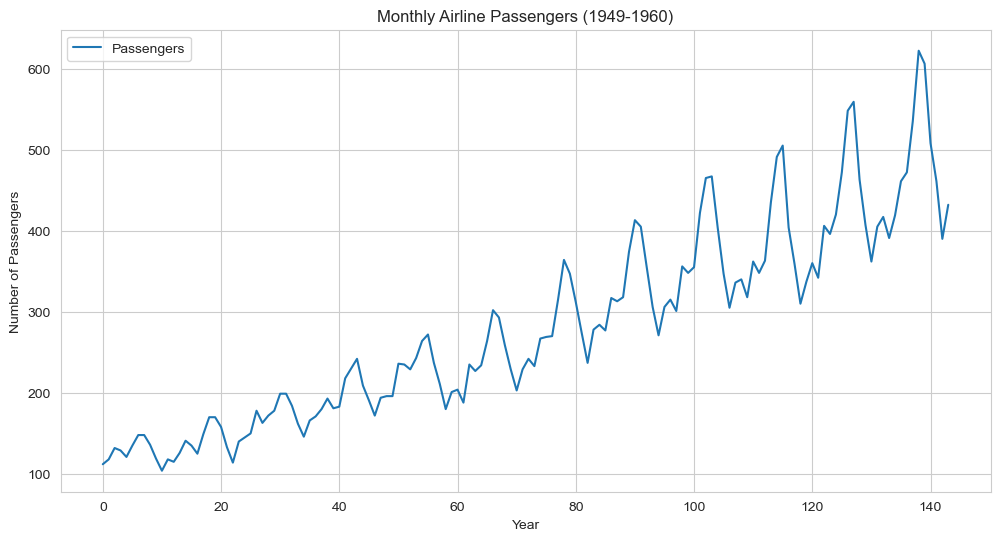

In [4]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

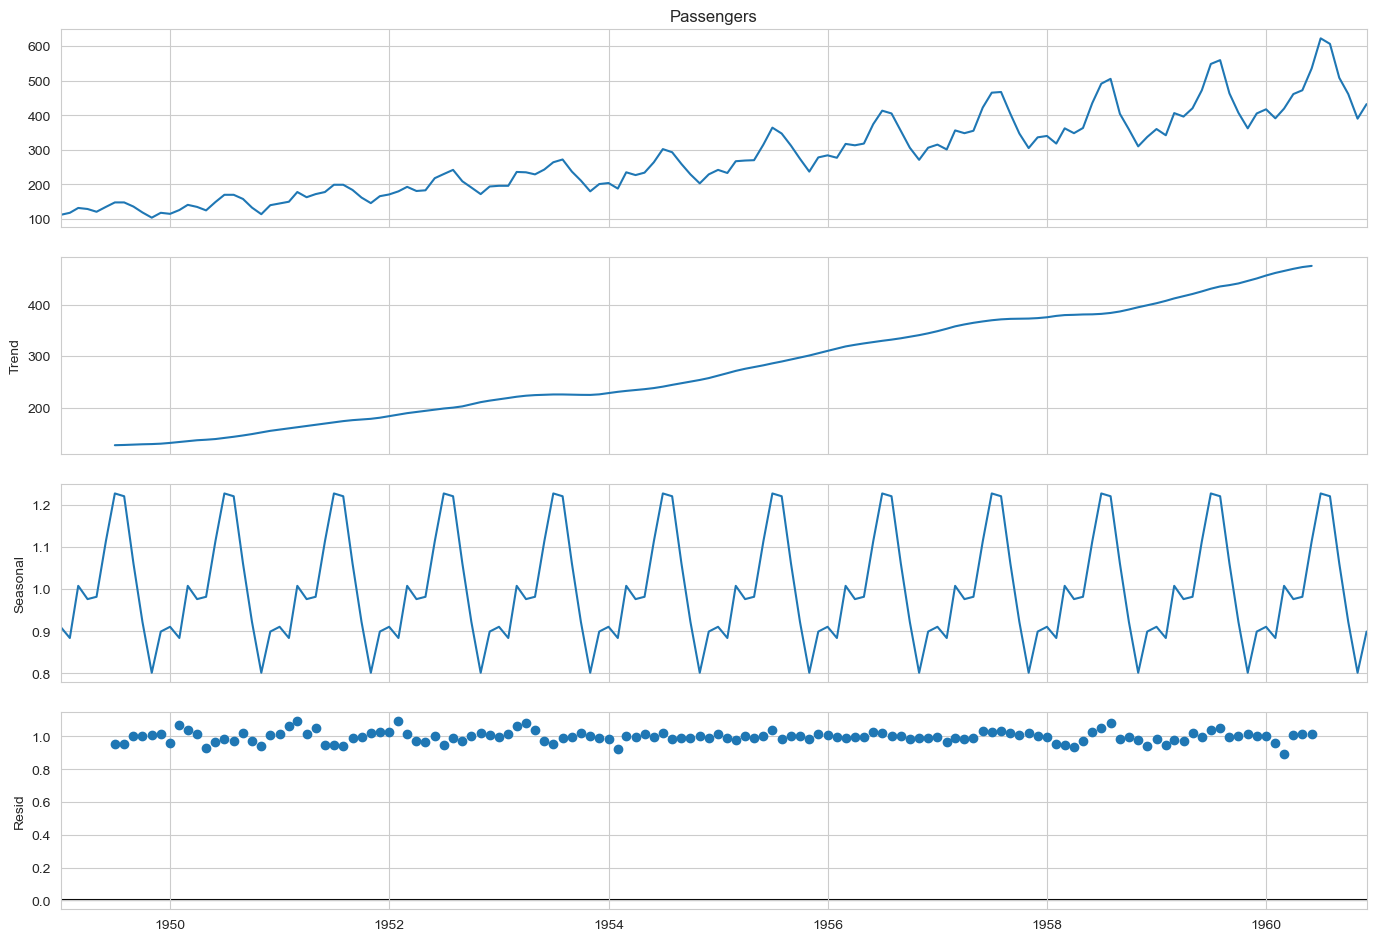

In [5]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


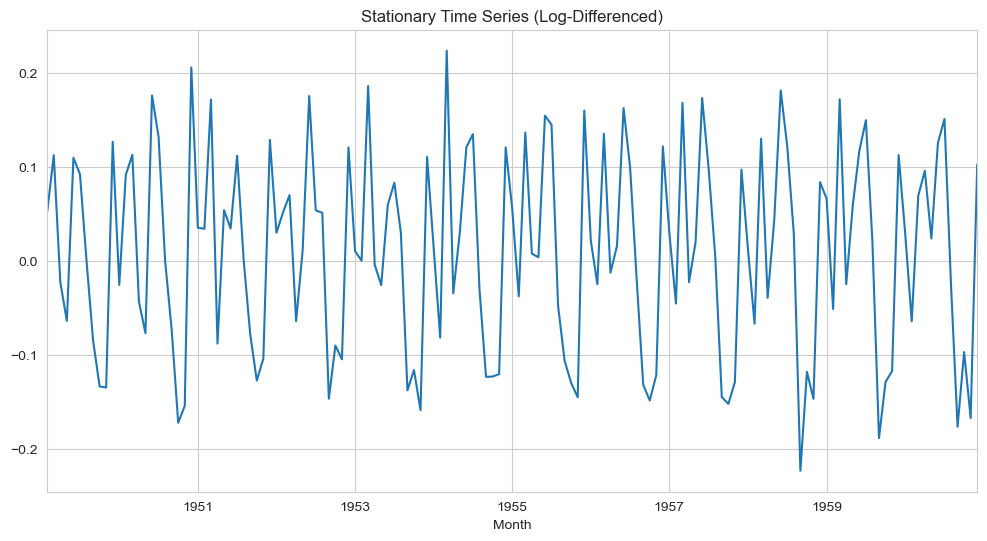

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [7]:
df_log = np.log(df['Passengers'])
df_diff = df_log.diff().dropna()
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

test_stationarity(df_diff)

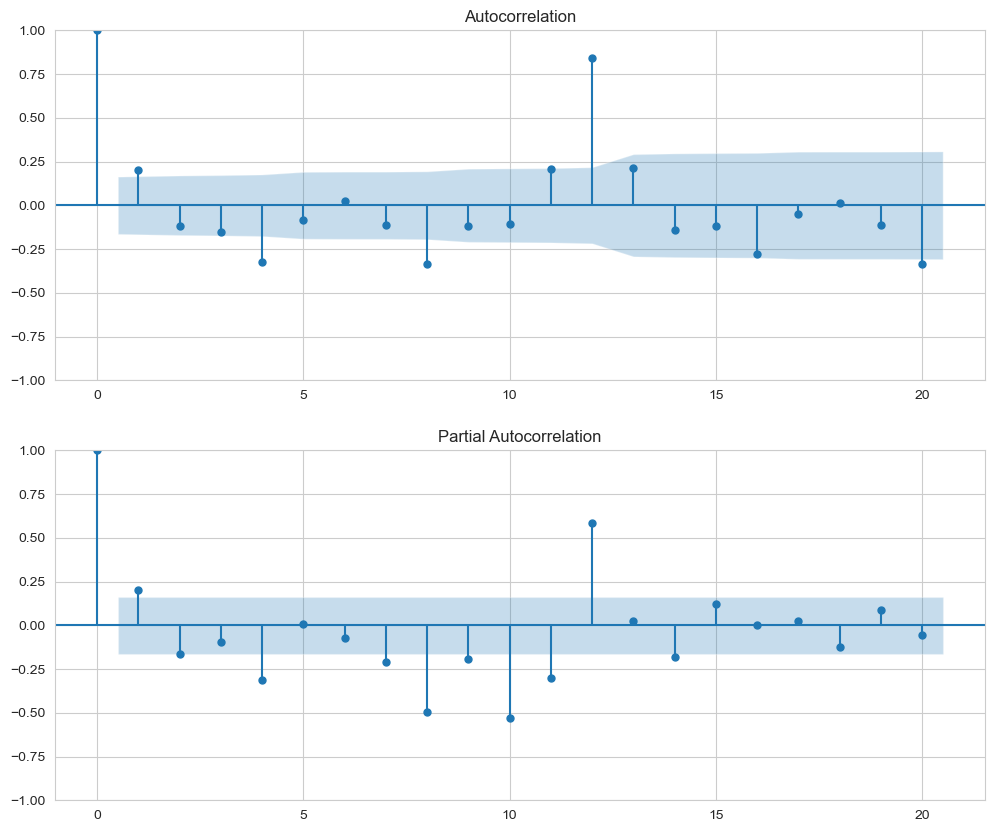

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

C:\Users\KIIT0001\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


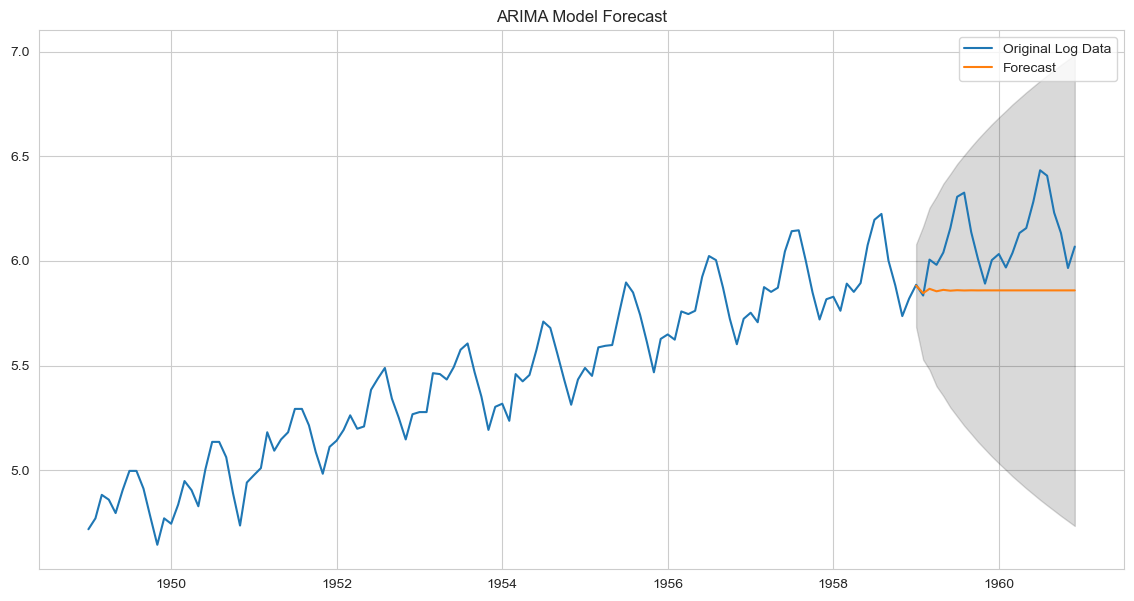

In [18]:
train_data = df_log[:'1958']
test_data = df_log['1959':]
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

C:\Users\KIIT0001\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


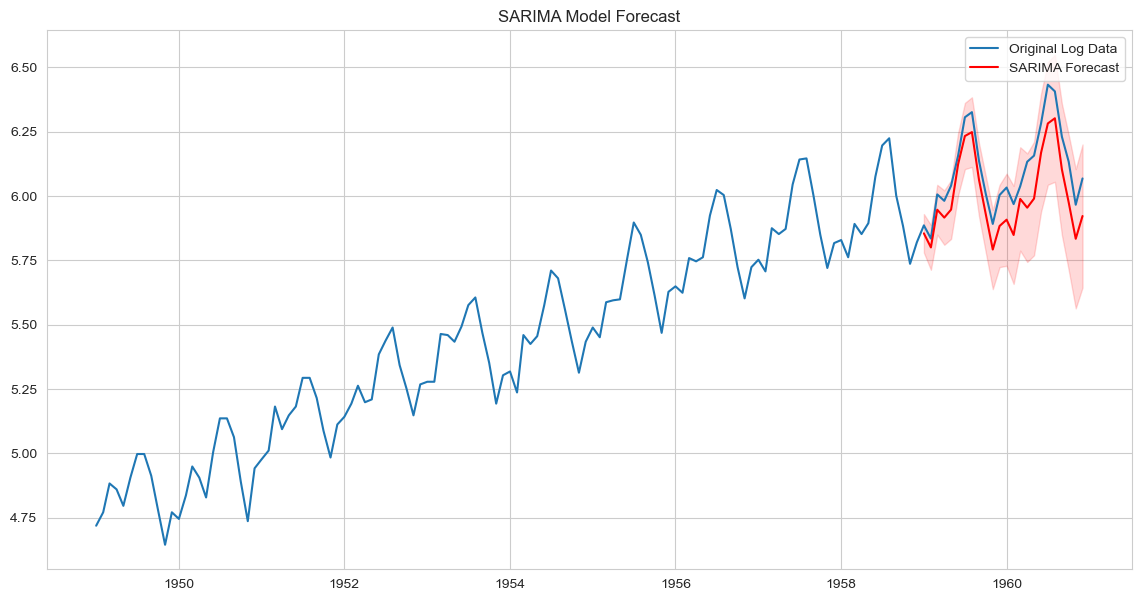

In [20]:
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit()

sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

SARIMA Model RMSE: 48.25


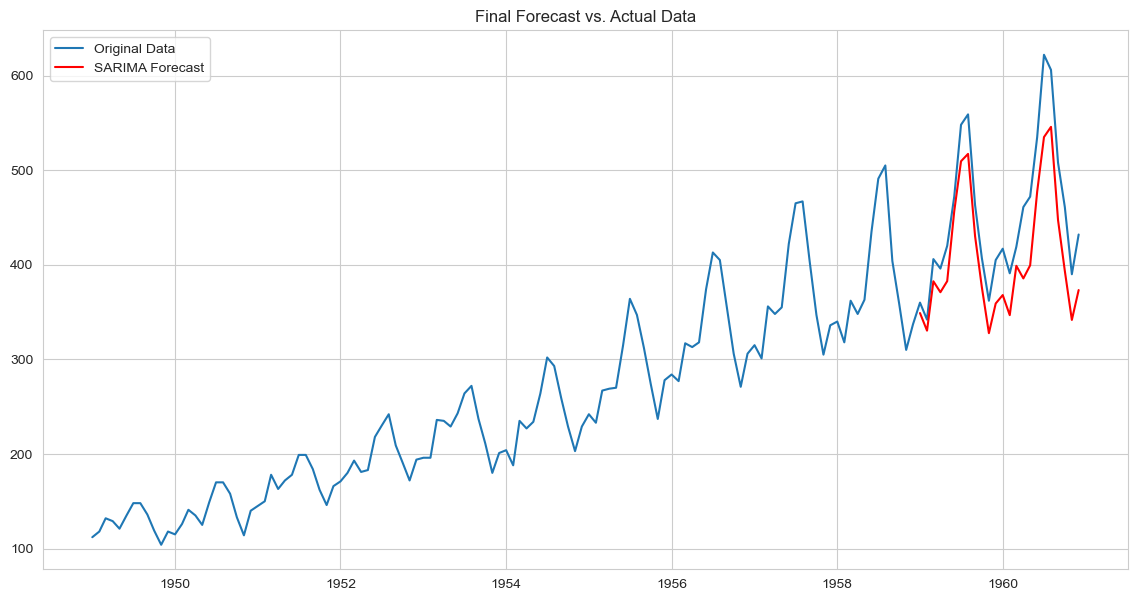

In [22]:
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

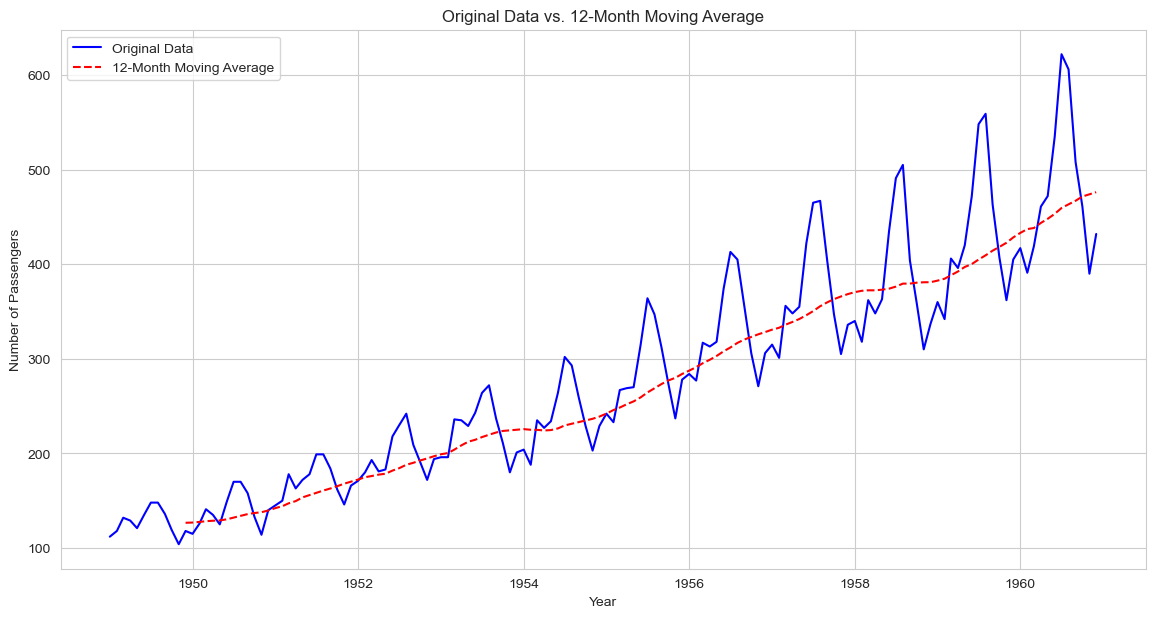

In [24]:
df['MovingAverage'] = df['Passengers'].rolling(window=12).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.title('Original Data vs. 12-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

C:\Users\KIIT0001\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\KIIT0001\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


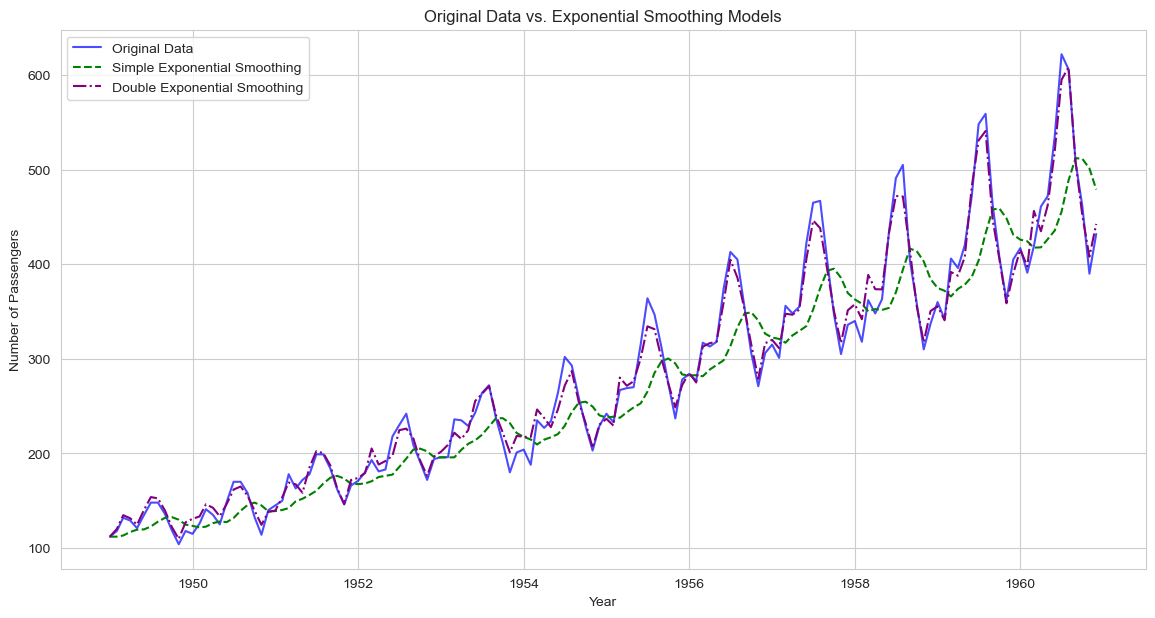

In [26]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

ses_model = SimpleExpSmoothing(df['Passengers']).fit(smoothing_level=0.2, optimized=False)
df['SimpleExpSmoothing'] = ses_model.fittedvalues

des_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['DoubleExpSmoothing'] = des_model.fittedvalues

plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['SimpleExpSmoothing'], label='Simple Exponential Smoothing', color='green', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing', color='purple', linestyle='-.')
plt.title('Original Data vs. Exponential Smoothing Models')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

C:\Users\KIIT0001\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\KIIT0001\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


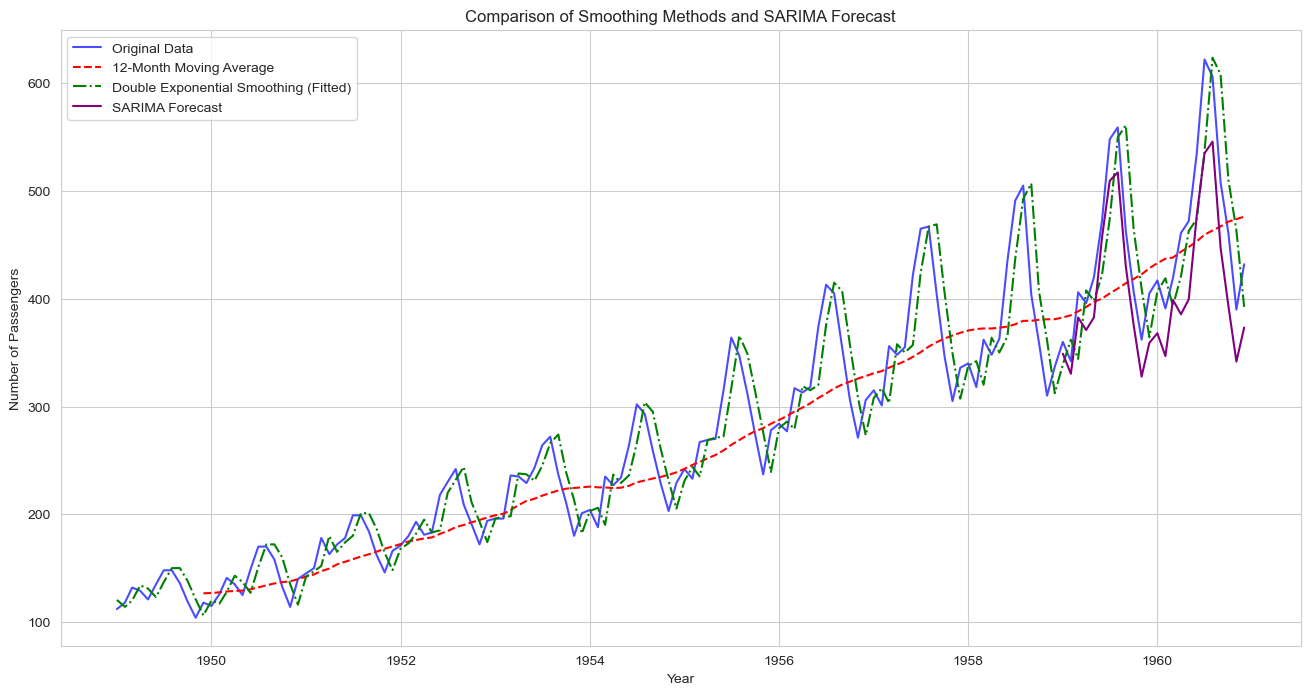

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')

train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [43]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

print("Columns found in CSV:", df.columns.tolist())

if 'Month' in df.columns:
    df['Month'] = pd.to_datetime(df['Month'])
    df.set_index('Month', inplace=True)
elif 'Date' in df.columns:

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
elif df.index.name == 'Month' or df.index.name == 'Date':

    print("Date column is already the index.")
else:

    df.columns = df.columns.str.strip()
    if 'Month' in df.columns:
        df['Month'] = pd.to_datetime(df['Month'])
        df.set_index('Month', inplace=True)
    else:
 
        print("Could not find 'Month' or 'Date'. Using the first column as the date.")
        first_col = df.columns[0]
        df[first_col] = pd.to_datetime(df[first_col])
        df.set_index(first_col, inplace=True)

if df.index.freq is None:
    df.index.freq = 'MS'

df['Passengers_Diff_2'] = df['Passengers'].diff().diff().dropna()

result = adfuller(df['Passengers_Diff_2'].dropna())
print('\nADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print("\n✅ Success: The p-value is less than 0.05. The data is stationary.")
    model = ARIMA(df['Passengers'], order=(1, 2, 1)) 
    model_fit = model.fit()
    print("\nARIMA Model Summary:")
    print(model_fit.summary())

Columns found in CSV: ['Passengers', 'MovingAverage', 'SimpleExpSmoothing', 'DoubleExpSmoothing', 'Passengers_Diff', 'Passengers_Diff_2']
Date column is already the index.

ADF Statistic: -16.384231542468527
p-value: 2.732891850014085e-29

✅ Success: The p-value is less than 0.05. The data is stationary.

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -696.464
Date:                Wed, 07 Jan 2026   AIC                           1398.928
Time:                        21:26:27   BIC                           1407.796
Sample:                    01-01-1949   HQIC                          1402.532
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err        